In [1]:
import numpy as np
from astropy.io import fits
from pylab import *

In [2]:
!pip install dpkt scapy

In [3]:
import dpkt
import scapy

In [4]:
from scapy.all import *


In [5]:
from craco.cardcap import get_single_packet_dtype
nant = 30
npol = 2
samp_per_int = 64 # samples per integration = 
samp_per_frame = 2048
int_per_frame = samp_per_frame // samp_per_int
nprod = nant*(nant+1)//2*npol # bug in nprod off by 1
dtype = get_single_packet_dtype(nprod, True)
packets_per_frame = int_per_frame * 36 * 4
dtype

dtype([('frame_id', '<u8'), ('bat', '<u8'), ('beam_number', 'u1'), ('sample_number', 'u1'), ('channel_number', 'u1'), ('fpga_id', 'u1'), ('nprod', '<u2'), ('flags', 'u1'), ('zero1', 'u1'), ('version', '<u4'), ('zero3', '<u4'), ('data', '<i2', (930, 2))])

In [14]:
last_ts = None
diffs = []
fout = open('packets.bin', 'wb')
fname = '/tmp/traces/tuesday_fixmeta_2.pcap'

fname = '/tmp/traces/tuesday_fixmeta_polsum_moreint.pcap'
fname = '/tmp/traces/tuesday_fixmeta_polsum_moreint.pcap'
fname = '/tmp/traces/tuesday_mettermeta.pcap'
fname = '/tmp/traces/wed_debug_2.pcap'
fname = '/tmp/traces/mp_thurs_2.pcap'

f = open(fname, 'rb')
pcap = dpkt.pcap.Reader(f)

send_first_packet_number_in_wireshark = 462
for ipkt, (ts, buf) in enumerate(pcap):
    
    if last_ts is not None:
        diff = ts - last_ts
    else:
        diff = 0
        
    last_ts = ts
        
    #print(ipkt, str(datetime.datetime.utcfromtimestamp(ts)), len(buf), diff*1e6, buf[66:74])              
    eth = dpkt.ethernet.Ethernet(buf)
    diffs.append(diff)
    
    if len(buf) == 4166: # full size packet
        payload = buf[66:-4] # remove CRC
    else:
        payload = buf[66+4:-4] # With immediate adn remove CRC
        
    if ipkt >= send_first_packet_number_in_wireshark - 1: # first SEND_FIRST packet
        fout.write(payload)
                
    if ipkt == 50000:
        break
        
fout.close()
        
   


npackets_per_frame=4608
23.87152777777778


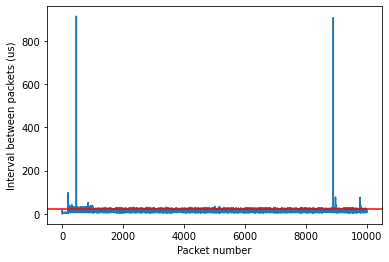

In [15]:
plot(np.array(diffs[:50000])*1e6)
xlabel('Packet number')
ylabel('Interval between packets (us)')
nint_per_frame = 2048//32 // 2
npackets_per_frame = 36*4*nint_per_frame
print(f'npackets_per_frame={npackets_per_frame}')
expected_interval = 110e-3/npackets_per_frame
print(expected_interval*1e6)
axhline(expected_interval*1e6, c='r')
#ylim(0,100)

In [16]:
packets = np.fromfile('packets.bin', dtype=dtype)

In [17]:
packets[:16]['frame_id']

array([3278848, 3278880, 3278912, 3278944, 3278976, 3279008, 3279040,
       3279072, 3279104, 3279136, 3279168, 3279200, 3279232, 3279264,
       3279296, 3279328], dtype=uint64)

In [18]:
(packets['frame_id'][1:] - packets['frame_id'][:-1])[:1024]

array([                  32,                   32,                   32,
       ...,                   32,                   32,
       18446744073709549600], dtype=uint64)

Text(0, 0.5, 'frame_id')

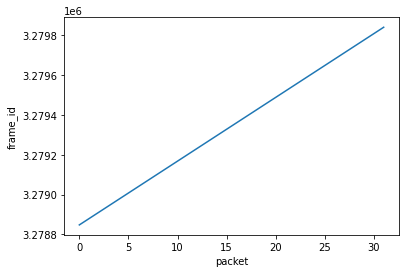

In [19]:
plot(packets['frame_id'][:32])
xlabel('packet')
ylabel('frame_id')


[33 31 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32]
[3279872 3279905 3279936 3279968 3280000 3280032 3280064 3280096 3280128
 3280160 3280192 3280224 3280256 3280288 3280320 3280352 3280384 3280416
 3280448 3280480 3280512 3280544 3280576 3280608 3280640 3280672 3280704
 3280736 3280768 3280800 3280832 3280864]


Text(0, 0.5, 'FrameID increment')

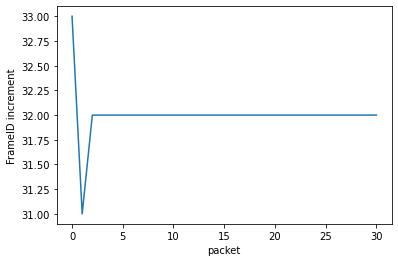

In [20]:
fid = packets['frame_id']
fdiff = fid[1:] - fid[0:-1]
off = 32*93
plot(fdiff[off:31+off])
print(fdiff[off:31+off])
print(fid[off:32+off])
xlabel('packet')
ylabel('FrameID increment')


Text(0, 0.5, 'Message')

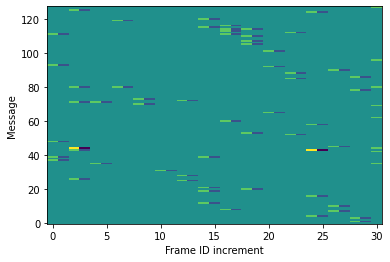

In [24]:
fdiff = fid[1:] - fid[0:-1]
off = 32*30
fr = fdiff[:32*128].reshape(-1,32)
imshow(fr[:,:-1], aspect='auto', origin='lower', interpolation='none')
xlabel('Frame ID increment')
ylabel('Message')
#gcf().set_size_inches((12,10))

Text(0, 0.5, 'bat')

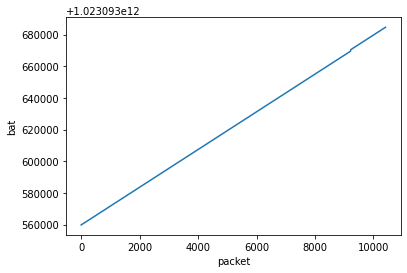

In [25]:
plot(packets['bat'])
xlabel('packet')
ylabel('bat')

Text(0, 0.5, 'BAT increment')

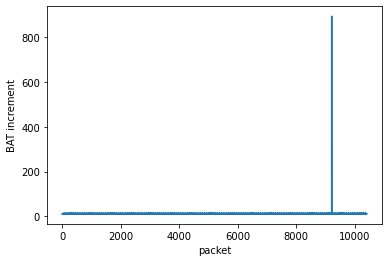

In [26]:
bat = packets['bat']
batdiff = bat[1:] - bat[:-1]
plot(batdiff[:])
xlabel('packet')
ylabel('BAT increment')

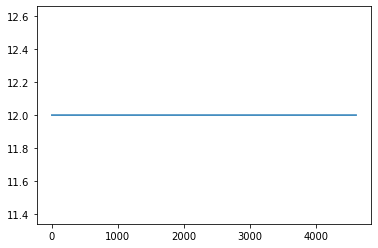

In [27]:
plot(packets['flags'][:npackets_per_frame])


In [28]:
dtype.itemsize

3752

In [29]:
32+929*4

3748

In [30]:
dtype

dtype([('frame_id', '<u8'), ('bat', '<u8'), ('beam_number', 'u1'), ('sample_number', 'u1'), ('channel_number', 'u1'), ('fpga_id', 'u1'), ('nprod', '<u2'), ('flags', 'u1'), ('zero1', 'u1'), ('version', '<u4'), ('zero3', '<u4'), ('data', '<i2', (930, 2))])

Text(0, 0.5, 'beam_number')

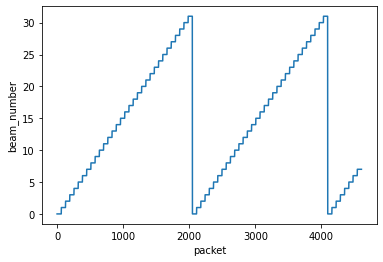

In [31]:
plot(packets['beam_number'][:npackets_per_frame])
xlabel('packet')
ylabel('beam_number')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


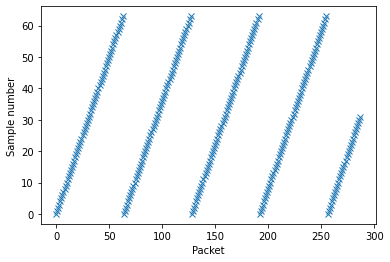

In [32]:
plot(packets['sample_number'][:npackets_per_frame//16],'x')
xlabel('Packet')
ylabel('Sample number')
print(packets['sample_number'][:16])
print(packets['sample_number'][16:32])
print(packets['sample_number'][32:48])

Text(0, 0.5, 'channel_number')

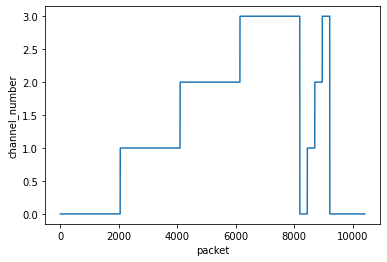

In [33]:
plot(packets['channel_number'])
xlabel('packet')
ylabel('channel_number')

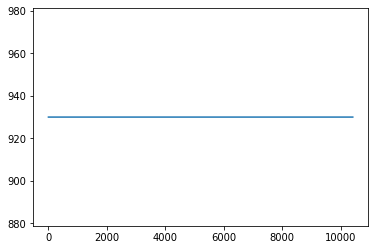

In [34]:
plot(packets['nprod'])

In [35]:
packets['data'].shape

(10413, 930, 2)

Text(0, 0.5, 'sample (beam/channel/time)')

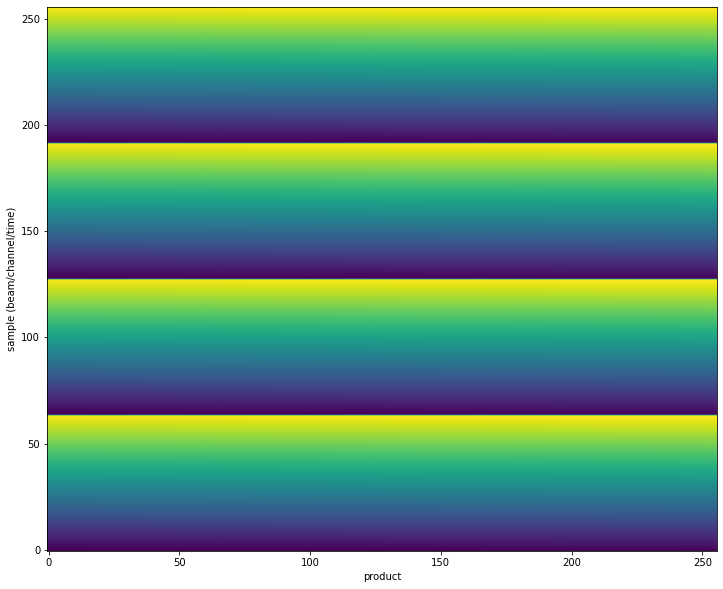

In [36]:
imshow(packets['data'][:256,:256,0], origin='lower', aspect='auto')
gcf().set_size_inches([12,10])
xlabel('product')
ylabel('sample (beam/channel/time)')


Things with nonzero real part 926
Things with nonzero imaginary part 0


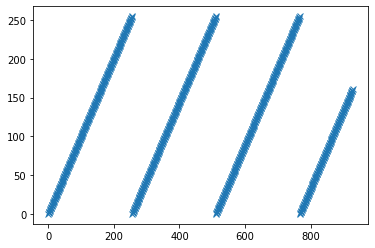

In [37]:
plot(packets['data'][0,:,0],'x')
print('Things with nonzero real part', np.sum(packets['data'][0,:,0]!=0))
print('Things with nonzero imaginary part', np.sum(packets['data'][0,:,1]!=0))
# antennas 4,5,6
# 1-1, 1-2, 1-3

In [ ]:
dtype

In [ ]:
np.where(packets['data'][0,:,0]!=0)[0]

In [ ]:
imag_idxs = np.where(packets['data'][0,:,1]!=0)[0]
print(imag_idxs)

In [13]:
nant = 36
addr = 0
addrmap = {}
for a1 in range(nant):
    for a2 in range(a1, nant):
        addrmap[addr] = (a1+1, a2+1)
        addr += 1
        
    
check_addr = [0,1,2,34,35,36,37,38,69,70,71,72,103,104,665]
for addr in check_addr:
    print(addr, addrmap[addr])



0 (1, 1)
1 (1, 2)
2 (1, 3)
34 (1, 35)
35 (1, 36)
36 (2, 2)
37 (2, 3)
38 (2, 4)
69 (2, 35)
70 (2, 36)
71 (3, 3)
72 (3, 4)
103 (3, 35)
104 (3, 36)
665 (36, 36)


In [9]:
preal = packets['data'][0,:,0]
pimag = packets['data'][0,:,1]


print(np.unique(preal))
        
"""
-23702 1
-20092 2
-19736 1
-16912 1
-15480 1
-13932 1
-13722 2
"""
for addr in np.where(preal!=0)[0]:
    if addr > len(addrmap):
        pol = "pol 2"
        bladdr = addr - len(addrmap)
    else: 
        pol = "pol 1"
        bladdr = addr
        
    print(f'RAM address={addr} pol={pol} baseline={addrmap[bladdr]} real={preal[addr]} imag={pimag[addr]}')

0 (1, 1)
1 (1, 2)
2 (1, 3)
3 (1, 4)
4 (1, 5)
5 (1, 6)
6 (1, 7)
7 (1, 8)
8 (1, 9)
9 (1, 10)
10 (1, 11)
11 (1, 12)
12 (1, 13)
13 (1, 14)
14 (1, 15)
15 (1, 16)
16 (1, 17)
17 (1, 18)
18 (1, 19)
19 (1, 20)
20 (1, 21)
21 (1, 22)
22 (1, 23)
23 (1, 24)
24 (1, 25)
25 (1, 26)
26 (1, 27)
27 (1, 28)
28 (1, 29)
29 (1, 30)
30 (2, 2)
31 (2, 3)
32 (2, 4)
33 (2, 5)
34 (2, 6)
35 (2, 7)
36 (2, 8)
37 (2, 9)
38 (2, 10)
39 (2, 11)
40 (2, 12)
41 (2, 13)
42 (2, 14)
43 (2, 15)
44 (2, 16)
45 (2, 17)
46 (2, 18)
47 (2, 19)
48 (2, 20)
49 (2, 21)
50 (2, 22)
51 (2, 23)
52 (2, 24)
53 (2, 25)
54 (2, 26)
55 (2, 27)
56 (2, 28)
57 (2, 29)
58 (2, 30)
59 (3, 3)
60 (3, 4)
61 (3, 5)
62 (3, 6)
63 (3, 7)
64 (3, 8)
65 (3, 9)
66 (3, 10)
67 (3, 11)
68 (3, 12)
69 (3, 13)
70 (3, 14)
71 (3, 15)
72 (3, 16)
73 (3, 17)
74 (3, 18)
75 (3, 19)
76 (3, 20)
77 (3, 21)
78 (3, 22)
79 (3, 23)
80 (3, 24)
81 (3, 25)
82 (3, 26)
83 (3, 27)
84 (3, 28)
85 (3, 29)
86 (3, 30)
87 (4, 4)
88 (4, 5)
89 (4, 6)
90 (4, 7)
91 (4, 8)
92 (4, 9)
93 (4, 10)
94 (4,

NameError: name 'preal' is not defined

In [ ]:
preal.shape

In [ ]:
addrmap[7]

In [ ]:
plot(packets['data'][:36*4*2,7,0])
gcf().set_size_inches((12,10))

In [ ]:
v = packets['data'][:64*36*4,7,0].reshape(-1,32)

In [ ]:
imshow(v, aspect='auto', origin='lower', interpolation='none')
gcf().set_size_inches((10,12))
xlabel('Integration number')
ylabel('Channel / beam / frame')

In [ ]:
np.all(packets['zero2'] == 2004071455)

In [ ]:

hist(preal[preal!=0], bins=1000)
print(len(np.unique(preal)))
print(np.unique(preal))
sum(preal!=0)


In [ ]:
for v in np.unique(preal):
    print(v, sum(preal==v))
    
